In [23]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from random import randint
import math

# Submodular Maximization

## Submodular Set Functions
Submodular set functions are the class of discrete functions that exhibit the Diminishing Returns (DR) property. To be precise, consider a ground set $V$ and a set function $f$ defined over the subsets of $V$. $f$ is called submodular if for item $j\in V$ and any two sets $A$ and $B$ such that $A\subseteq B\subseteq V\setminus \{j\}$, we have:
$$ 
f(A\cup \{j\})-f(A)\geq f(B\cup \{j\})-f(B).
$$
In other words, the marginal gain of adding a certain item to the set diminishes as the set grows larger.  
As an example, let $V$ be the set of locations in space where we can place sensors and assume that placing a sensor in a place covers a circular area around it. In this example, $f(S):S\subseteq V$ denotes the total area covered by sensors placed at locations $S$.  

<img src="./sensor.png"/>

We can define submodular set functions in the following equivalent way as well: $f$ is submodular if for any two sets $A,B\subseteq V$, the following holds:
$$
f(A)+f(B)\geq f(A\cup B)+f(A\cap B).
$$

## Applications
Submodular set functions play a significant role in combinatorial optimization as many well known combinatorial functions are indeed submodular. A few examples are:
- Cut functions of graphs and hypergraphs 
- Rank functions of matroids 
- Covering functions  

Moreover, submodularity has been identified and utilized in applications such as viral marketing, feature selection for classification, image segmentation and document summarization.

<a id="MlE"></a>
## Multilinear Extension
The multilinear extension $F:[0,1]^V \rightarrow \mathbb{R}$ of $F$ is defined as
$$
F(x)=\sum_{S\subset V}f(S)\prod_{i\in S}x_i \prod_{j\notin S}(1-x_j)=\mathbb{E}_{S\sim x}[f(S)].
$$
For example, consider the set function $f(x_1,x_2,x_3)=2x_1+3x_2+x_3-x_1x_2-2x_2x_3$ where $x_i\in \{0,1\};i=1,2,3$ indicate whether the $i$-th item is in the set. The multilinear extension of $f$ is $F(x_1,x_2,x_3)=2x_1+3x_2+x_3-x_1x_2-2x_2x_3$ for $x_i\in [0,1];i=1,2,3$. We can see below that $F$ is neither convex or concave. In particular, if we choose $z_1=(0.5,0.5,0.5)$, $v_1=(0.5,-0.5,0)$, $z_2=(0,0,0)$ and $v_2=(1,1,1)$, $F(z_1+tv_1)$ and $F(z_2+tv_2)$ are convex and concave respectively as a function of $t\in[0,1]$.

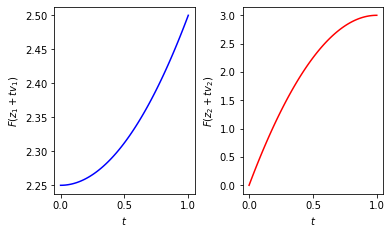

In [24]:
z1=np.array([0.5,0.5,0.5])
v1=np.array([0.5,-0.5,0])
z2=np.zeros(3)
v2=np.ones(3)
def F(x):
    return 2*x[0]+3*x[1]+x[2]-x[0]*x[1]-2*x[1]*x[2]
T=np.linspace(0,1,100)
F1=np.zeros(100)
F2=np.zeros(100)
for i in range(100):
    F1[i]=F(z1+T[i]*v1)
    F2[i]=F(z2+T[i]*v2)
plt.subplot(1,2,1)
plt.tight_layout(pad=4.0)
plt.plot(T,F1,color='blue')
plt.xlabel('$t$')
plt.ylabel('$F(z_1+tv_1)$')
plt.subplot(1,2,2)
plt.xlabel('$t$')
plt.ylabel('$F(z_2+tv_2)$')
plt.plot(T,F2,color='red')

In general, multilinear extension of submodular set functions are concave along non-negative directions, i.e., $F(x+tv)$ is a concave function of $t$ if $v$ in entry-wise non-negative (or non-positive). This property is particularly useful in the design of continuous algorithms for maximizing multilinear extension of submodular set functions.

## Monotone Submodular Maximization Algorithms
In this notebook, we focus on submodular set functions that are monotone, i.e., for $A\subseteq B\subseteq V$, $f(A)\leq f(B)$ holds. It is easy to see that unconstrained monotone submodular maximization problems $\max_{S\subseteq V}f(S)$ are trivial because adding more items to the set always increases the objective value and therefore, $\max_{S\subseteq V}f(S)=f(V)$ always holds.   
We study constrained monotone submodular maximization problems under two common constraints: 
- Cardinality (size) constraint
- Matroid constraint

### Monotone Submodular Maximization Under Cardinality Constraint
Consider the optimization problem $\max_{S\subseteq V:|S|\leq k}f(S)$ where $k<|V|$ is the maximium size of feasible sets. We study the greedy algorithm for solving this problem. The algorithm works as follows:  
> Set $S=\emptyset$ and $U=V$.  
> for all $i=1,\dots,k$:

>> choose $v_i=arg\max_{j\in U}\big(f(S\cup \{j\})-f(S)\big)$.  
>> Set $S=S\cup \{v_i\}$ and $U=V\setminus \{v_i\}$.   

> end for    
> Output $S$.

At each step $i\in\{1,\dots,k\}$, the greedy algorithms simply computes the marginal gain of adding each of the remaining items to the current set, and chooses the item $v_i$ with the highest marginal gain. [Nemhauser et al.](https://link.springer.com/article/10.1007/BF01588971) showed that the greedy algorithm obtain the approximation ratio $1-\frac{1}{e}$ for monotone submodular maximization subject to cardinality constraints and they also proved matching lower bounds for the approximation guarantee.

#### Implementation
In the example below, we define each item $v\in V$ to be a random subset of $\{1,\dots,50\}$ and we set $f(S)=|\cup_{v \in S}v|$. It is easy to see that $f$ is a monotone submodular set function. We set the cardinality constraint $k=9$ and we plot the objective value during the executation of the algorithm.

Text(0, 0.5, '$f(S)$')

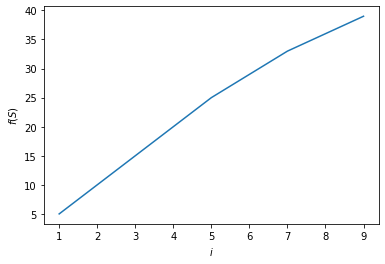

In [25]:
V=[]
k=9
def f(S):
    return len(S)

for s in range(50):
    V.append(set([randint(1,50) for j in range(5)]))
val=np.zeros(k)
S=set()
U=V
for i in range(k):
    j=np.argmax([f(S.union(U[s])) for s in range(len(U))])
    S=S.union(U[j])
    val[i]=f(S)
    U.pop(j)
plt.plot(range(1,k+1),val)
plt.xlabel('$i$')
plt.ylabel('$f(S)$')

### Monotone Submodular Maximization Under Matroid Constraint
While the greedy algorithm is able to obtain the provably optimal $1-\frac{1}{e}$ approximation for monotone submodular set function maximization subject to cardinality constraint, this result does not extend to more general constraints. To see this, let's first define matroids. A matroid $\mathcal{M}$ is a pair $\mathcal{M}=(V,\mathcal{I})$, where $V$ is the ground set and $\mathcal{I}$ is a collection of subsets of $V$ called the independent sets, that satisfies the following properties:
1) $\emptyset \in \mathcal{I}$.
2) For $S'\subset S \subset V$, if $S\in \mathcal{I}$, then $S'\in \mathcal{I}$ holds. 
3) For $S,S'\in \mathcal{I}$, if $|S|>|S'|$, there exists $v\in S\setminus S'$ such that $S'\cup \{v\}\in \mathcal{I}$.

As an example, the cardinality constraint is a special case of a matroid constraint with independent sets $\mathcal{I}=\{S\subseteq V:|S|\leq k\}$.

The greedy algorithm applied to monotone submodular maximization subject to a matroid constraint only manages to achieve a $\frac{1}{2}$ approximation ratio. Therefore, we study a *continuous* algorithm, called the [**Continuous Greedy**](https://epubs.siam.org/doi/10.1137/080733991) algorithm, that is applied to the multilinear extension of the submodular set function and produces a fractional solution with the optimal approximation ratio $1-\frac{1}{e}$. Combining the continuous greedy algorithm and lossless rounding techniques such as [pipage rounding](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjv0P-UwfzzAhUDrp4KHShVA1kQFnoECAUQAQ&url=http%3A%2F%2Fwww.cs.toronto.edu%2Ftss%2Ffiles%2Fpapers%2FAgeev-Sviridenko2004_Article_PipageRoundingANewMethodOfCons.pdf&usg=AOvVaw07QGri7Hlfz8iKR0r3I1rI) or [swap rounding](https://theory.stanford.edu/~jvondrak/data/matroid-rounding.pdf), we can obtain a set with similar performance guarantee.

Consider the optimization problem $\max_{S\in \mathcal{I}}f(S)$ where $\mathcal{I}$ is the collection of the independent sets of the matroid $\mathcal{M}=(V,\mathcal{I})$. The matroid polytope corresponding to the matroid $\mathcal{M}$ is defined as
$$
P(\mathcal{M})={\rm conv}\{1_I:I\in \mathcal{I}\}=\{x\succeq 0:\sum_{s\in S}x_s\leq r_{\mathcal{M}}(S),~\forall S\subset V\},
$$ 
where the rank function $r_{\mathcal{M}}:2^V\to \mathbb{Z}_+$ is $r_{\mathcal{M}}(S)=\max \{|I|:I\subseteq S,I\in \mathcal{I}\}$ and conv denotes the convex hull. We define ${\rm rank}(\mathcal{M})=r_{\mathcal{M}}(V)$ as the rank of the matroid $\mathcal{M}$. For the special case of the cardinality constraint, rank of the matroid equals the size $k$.

We consider the continuous counterpart $\max_{x\in P(\mathcal{M})}F(x)$ of the original optimization problem. The continuous greedy algorithm runs as follows:  
> Set $K=9{\rm rank}^2(\mathcal{M})$ and $x_1=0$.  
> for all $k=1,\dots,K$:

>> Compute $v_k=arg\max_{x\in P(\mathcal{M})}\langle \nabla f(x_k),x \rangle$.  
>> Set $x_{k+1}=x_k+\frac{1}{K}v_k$.  

> end for     
> Ouptut $x_{K+1}$.    

For all $k\in [K]$, the optimization problem for computing $v_k$ is a linear maximization problem over the matroid polytope and therefore, the optimal point $v_k$ is always a vertex of the polytope, i.e., an independent set of the matroid $\mathcal{M}$ (according to the definition of the matroid polytope as the convex hull of independent sets of the matroid). Also, we can use the definition of the multilinear extension function and write:
$$
\nabla_i f(x_k)=\mathbb{E}_{R_k\sim x_k}[f(R_k\cup \{i\})]-\mathbb{E}_{R_k\sim x_k}[f(R_k\setminus \{i\})].
$$
In many cases, the multilinear extension has a closed form (e.g., the example in [Multilinear Extension](#MlE)) and it is easy to compute the gradient. However, for more general cases, we can take the average of sufficient number of independent samples of $R_k$ to compute an accurate estimate of the gradient with high probability.

#### Implementation
We implement the continuous greedy algorithm on the *submodular welfare maximization problem* introduced below:

We are given a set of $m$ items $X$ and $n$ players each with a separate monotone submodular utility function $f_i$. The goal is to partition the items $X$ into disjoint subsets $S_1,\dots,S_n$ to maximize the social welfare $\sum_{i=1}^n f_i(S_i)$. We first show that this problem could be reformulated as a monotone submodular maximization problem subject to a matroid constraint. Define $V=\{1,\dots,n\}\times X$ and for each player $i\in[n]$, let $\pi_i:2^V\to 2^X$ be the mapping $\pi_i(S)=\{j\in X:(i,j)\in S\}$. The submodular welfare problem is equivalent to finding $S=\cup_{i=1}^n(\{i\}\times S_i)\subseteq V$, where $S_1,\dots,S_n$ are disjoint, so that $\sum_{i=1}^n f_i(\pi_i(S))=\sum_{i=1}^n f_i(S_i)$ is maximized. The disjoint partition condition could be rewritten as a special matroid constraint called the *partition matroid* over $V$ with the following independent sets:
$$
\mathcal{I}=\{S\subseteq V:|S\cap X_j|\leq 1~\forall j\in[m]\},
$$
where $X_j=\{1,\dots,n\}\times\{j\}$. Rank of this partition matroid is $m=|X|$.   
For all $i\in[n]$, we define $f_i(x)=c_i^Tx+\frac{1}{2}x^TA_ix$ for $x\in [0,1]^m$ where $A_i$ is an entry-wise non-positive matrix and $c_i$ is element-wise positive. It is easy to see that the multilinear extension $F_i$ has the exact same form as well. The quadratic term in the objective function is used to penalize similarity between the allocated items to a certain player.

In [26]:
m=10
n=5
K=9*(m)**2
A1=np.zeros((m,m))
c1=[randint(10,16) for s in range(m)]
A1[:3,:3]=np.random.uniform(-2,0,(3,3))
A1[3:7,3:7]=np.random.uniform(-2,0,(4,4))
A1[7:,7:]=np.random.uniform(-2,0,(3,3))
A1=(A1+A1.T)/2
A2=np.zeros((m,m))
c2=[randint(10,16) for s in range(m)]
A2[:5,:5]=np.random.uniform(-2,0,(5,5))
A2[5:,5:]=np.random.uniform(-2,0,(5,5))
A2=(A2+A2.T)/2
A3=np.zeros((m,m))
c3=[randint(11,16) for s in range(m)]
A3[3:5,3:5]=np.random.uniform(-5,0,(2,2))
A3[6:8,6:8]=np.random.uniform(-5,0,(2,2))
A3=(A3+A3.T)/2
A4=np.zeros((m,m))
c4=[randint(12,16) for s in range(m)]
A4[2:7,2:7]=np.random.uniform(-3,0,(5,5))
A4=(A4+A4.T)/2
A5=np.zeros((m,m))
c5=[randint(11,16) for s in range(m)]
A5[1:4,1:4]=np.random.uniform(-2,0,(3,3))
A5[5:9,5:9]=np.random.uniform(-2,0,(4,4))
A5=(A5+A5.T)/2
for i in range(m):
    A1[i,i]=0
    A2[i,i]=0
    A3[i,i]=0
    A4[i,i]=0
    A5[i,i]=0
def f1(x):
    return np.dot(c1,x)+np.dot(0.5*x.T,np.dot(A1,x))
def grad1(x):
    return c1+np.dot(A1,x)
def f2(x):
    return np.dot(c2,x)+np.dot(0.5*x.T,np.dot(A2,x))
def grad2(x):
    return c2+np.dot(A2,x)
def f3(x):
    return np.dot(c3,x)+np.dot(0.5*x.T,np.dot(A3,x))
def grad3(x):
    return c3+np.dot(A3,x)
def f4(x):
    return np.dot(c4,x)+np.dot(0.5*x.T,np.dot(A4,x))
def grad4(x):
    return c4+np.dot(A4,x)
def f5(x):
    return np.dot(c5,x)+np.dot(0.5*x.T,np.dot(A5,x))
def grad5(x):
    return c5+np.dot(A5,x)


In [27]:
x=np.zeros((n,m))
g=np.zeros((n,m))
val=np.zeros(K)
for k in range(K):
        g[0,:]=grad1(x[0,:])
        g[1,:]=grad2(x[1,:])
        g[2,:]=grad3(x[2,:])
        g[3,:]=grad4(x[3,:])
        g[4,:]=grad5(x[4,:])
        for j in range(m):
                ind=np.argmax(g[:,j])
                x[ind,j]+=(1/K)
        val[k]=f1(x[0,:])+f2(x[1,:])+f3(x[2,:])+f4(x[3,:])+f5(x[4,:])

Text(0, 0.5, '$F_i(x_i)$')

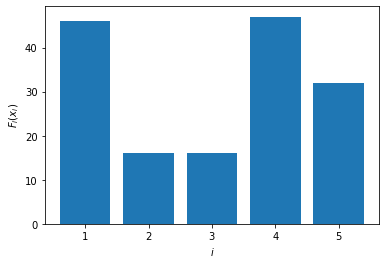

In [28]:
plt.bar(range(1,n+1),[f1(x[0,:]),f2(x[1,:]),f3(x[2,:]),f4(x[3,:]),f5(x[4,:])])
plt.xticks([1,2,3,4,5])
plt.xlabel('$i$')
plt.ylabel('$F_i(x_i)$')